## Objective - To apply KNN on Amazon Fine Food Reviews Data using all four Vectorizer.
1. Bag of Words
2. Tf-idf
3. AVG - W2V
4. TF-idf W2v

In [71]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from prettytable import PrettyTable
import random
from sklearn.metrics import roc_curve, auc
from sklearn.learning_curve import validation_curve
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import precision_score, recall_score,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

#import nltk
#nltk.download('stopwords')

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#from gensim.models import KeyedVectors
#model = KeyedVectors.load_word2vec_format(‘GoogleNews-vectors-negative300.bin.gz’,binary=True)

#import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [72]:
con = sqlite3.connect('/Users/mohdsaquib/Documents/Data/database.sqlite') 

In [73]:
filtered_data  = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3  """, con) 
print(filtered_data.shape)

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print(filtered_data.shape)

(525814, 10)
(525814, 10)


In [74]:
#Sorting 40K data according to TimeStamp in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.count()
print(type(sorted_data))

#Deduplication of entries
final2=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final = final2.head(40000) #selecting first 40K rows of data based on TimeStamp
final.shape

<class 'pandas.core.frame.DataFrame'>


(40000, 10)

In [75]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE HelpfulnessNumerator > HelpfulnessDenominator 
ORDER BY ProductID
""", con)

display.head()
final.shape

(40000, 10)

In [76]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

8
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his 

In [77]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'it', 'yours', 'down', "couldn't", 'each', 'so', "that'll", 'd', 'who', 'again', 'through', 'further', 'doing', 'an', 'i', 'has', 'not', 'these', "needn't", "it's", 'doesn', 'only', 'his', 'the', 'wasn', 'than', 'yourselves', 'to', 'about', 'until', 'up', 'if', 'out', 'yourself', "haven't", 'what', 'off', 'you', 'weren', 't', 'during', 'too', 'shan', 'for', 'at', 'nor', 'hasn', 'been', 'is', 's', 'they', 'himself', 'between', 'or', 'above', 'our', 'them', "don't", 'y', 'such', 'which', "she's", "you've", "doesn't", 'into', 'are', 'as', 'haven', 'shouldn', 'other', 'hadn', 'with', 'after', 'no', 'hers', 'your', 'theirs', "hasn't", 'below', "hadn't", 'can', 'o', 'some', 'there', 'me', 'own', "wasn't", 'most', "aren't", 'just', 'that', 'm', "isn't", 'her', 'myself', 'couldn', 'does', 'before', 'itself', 'needn', 'having', "wouldn't", "shan't", 'll', 'on', 'did', "mightn't", 'its', 'against', 'because', "won't", 'under', 'here', 'same', 'was', 'do', 'when', 'herself', 'but', 'any', 'had',

In [78]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 60K sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [79]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
print(final.shape)

(40000, 11)


In [80]:
# create design matrix X and target vector y
X = np.array(final.iloc[:,:]) # end index is exclusive
y = np.array(final['Score']) # showing you two ways of indexing a pandas df

In [81]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_train, X_cv, y_train, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


### Bag of Words

In [82]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train[:,9]) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train[:,9])
X_cv_bow = vectorizer.transform(X_cv[:,9])
X_test_bow = vectorizer.transform(X_test[:,9])
print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)

After vectorizations
(19600, 28012) (19600,)
(8400, 28012) (8400,)
(12000, 28012) (12000,)
(19600,)
(8400,)
(12000,)


### BoW KNN ( Brute-force) 

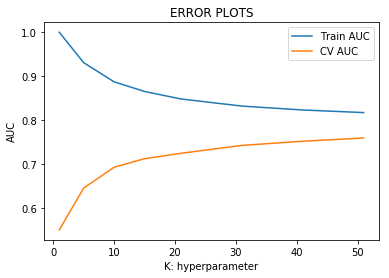

In [83]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    neigh.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

#### From above roc curve k=30 seems to be best hyperparameter.

In [84]:
## best hyperparameter
best_k = 30

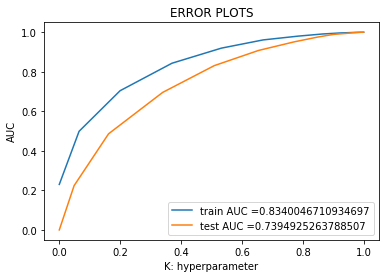

In [85]:
## finding roc_auc on test data
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

#### Train AUC  = 0.841
#### Test AUC = 0.7077

### Confusion Matrix

In [86]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_bow)))

Train confusion matrix
[[    6  2101]
 [    1 17492]]
Test confusion matrix
[[    6  1328]
 [    1 10665]]


#### Classification Report

In [87]:
from sklearn.metrics import classification_report
print(classification_report(y_test, neigh.predict(X_test_bow)))


             precision    recall  f1-score   support

          0       0.86      0.00      0.01      1334
          1       0.89      1.00      0.94     10666

avg / total       0.89      0.89      0.84     12000



### BoW KNN( Kd-Tree)

In [88]:
svd = TruncatedSVD()
X_train_bow_kd = svd.fit_transform(X_train_bow)
X_cv_bow_kd = svd.transform(X_cv_bow)
X_test_bow_kd = svd.transform(X_test_bow)

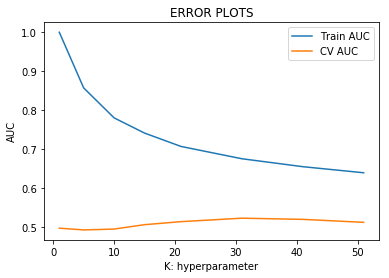

In [89]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(X_train_bow_kd, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_bow_kd)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_bow_kd)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### The best value of hyperparameter from above curve is k=30.

In [90]:
### best k 
best1_k = 30

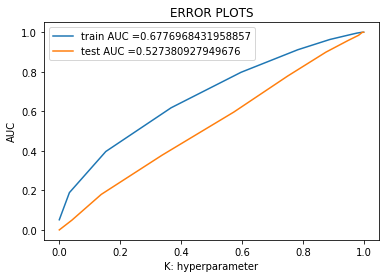

In [91]:
## finding roc_auc on test data
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best1_k)
neigh.fit(X_train_bow_kd, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_bow_kd)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bow_kd)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

#### Train AUC = 0.68
#### Test  AUC = 0.50


### Confusion Matrix

In [92]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_bow_kd)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_bow_kd)))

Train confusion matrix
[[    0  2107]
 [    0 17493]]
Test confusion matrix
[[    0  1334]
 [    0 10666]]


#### Classification report

In [93]:
from sklearn.metrics import classification_report
print(classification_report(y_test, neigh.predict(X_test_bow_kd)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1334
          1       0.89      1.00      0.94     10666

avg / total       0.79      0.89      0.84     12000



### Tf-idf

In [97]:
#tf-idf on train data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1)) #considering only uni-gram as I was getting memory error
train_tfidf = tf_idf_vect.fit_transform(X_train[:,9]) #sparse matrix
cv_tfidf= tf_idf_vect.transform(X_cv[:,9])
test_tfidf = tf_idf_vect.transform(X_test[:,9])
print(train_tfidf.shape)
print(cv_tfidf.shape)
print(test_tfidf.shape)

(19600, 28012)
(8400, 28012)
(12000, 28012)


###  TF-idf KNN ( Brute-Force)

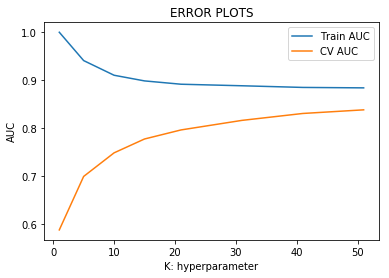

In [98]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    neigh.fit(train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(train_tfidf)[:,1]
    y_cv_pred =  neigh.predict_proba(cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [99]:
### best hyperparameter from above
best3_k = 30

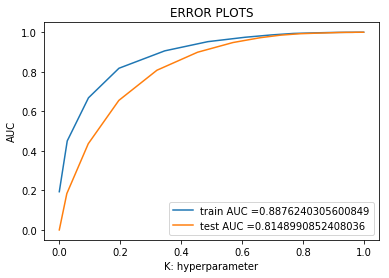

In [101]:
## finding roc_auc on test data
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best3_k)
neigh.fit(train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

#### Train AUC = 0.88
#### Test AUC = 0.81

### Confusion Matrix

In [103]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(test_tfidf)))

Train confusion matrix
[[   59  2048]
 [    2 17491]]
Test confusion matrix
[[   34  1300]
 [    0 10666]]


#### Classification Report

In [104]:
from sklearn.metrics import classification_report
print(classification_report(y_test, neigh.predict(test_tfidf)))

             precision    recall  f1-score   support

          0       1.00      0.03      0.05      1334
          1       0.89      1.00      0.94     10666

avg / total       0.90      0.89      0.84     12000



###  Tf-idf KNN ( Kd-Tree)

In [106]:
svd = TruncatedSVD()
train_tfidf_kd = svd.fit_transform(train_tfidf)
cv_tfidf_kd = svd.transform(cv_tfidf)
test_tfidf_kd = svd.transform(test_tfidf)

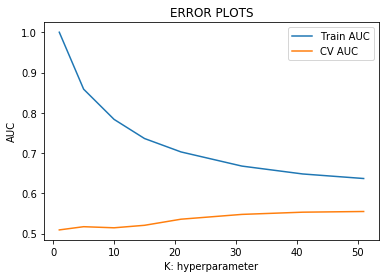

In [107]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(train_tfidf_kd, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(train_tfidf_kd)[:,1]
    y_cv_pred =  neigh.predict_proba(cv_tfidf_kd)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [110]:
### best hyperparameter from above
best_kd_k =30

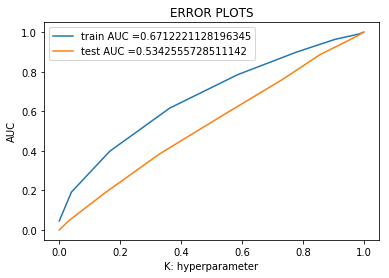

In [111]:
## finding roc_auc on test data
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_kd_k)
neigh.fit(train_tfidf_kd, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(train_tfidf_kd)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(test_tfidf_kd)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

####  Train AUC = 0.67
####  Test AUC = 0.53

### Confusion Matrix

In [112]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(train_tfidf_kd)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(test_tfidf_kd)))

Train confusion matrix
[[    0  2107]
 [    0 17493]]
Test confusion matrix
[[    0  1334]
 [    0 10666]]


#### Classification Report

In [113]:
from sklearn.metrics import classification_report
print(classification_report(y_test, neigh.predict(test_tfidf_kd)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1334
          1       0.89      1.00      0.94     10666

avg / total       0.79      0.89      0.84     12000



### Avg-W2V

In [124]:
#w2v
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())
    
print(type(list_of_sent))
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

<class 'list'>
witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [125]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [126]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
#print(len(sent_vectors[0]))
print(type(sent_vectors))

40000
<class 'list'>


In [ ]:
# create design matrix X and target vector y
X = np.array(sent_vectors[::]) # end index is exclusive
y = np.array(final['Score']) # showing you two ways of indexing a pandas df

In [183]:
# split the data set into train and test
X_1, X_test_avgw2v, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_train_avgw2v, X_cv_avgw2v, y_train, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


### Avg- W2V KNN (Brute-force)

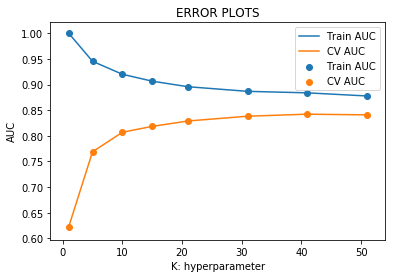

In [184]:
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm = 'brute')
    neigh.fit(X_train_avgw2v, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_avgw2v)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_avgw2v)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [185]:
### best hyperparameter
best_k_w2v = 15

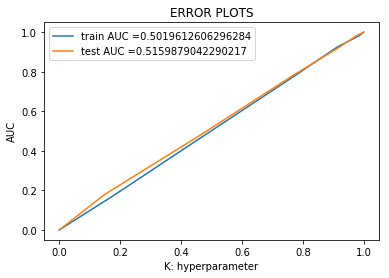

Train confusion matrix
[[    0  2109]
 [    2 17489]]
Test confusion matrix
[[    0  1334]
 [    1 10665]]


In [209]:
neigh = KNeighborsClassifier(n_neighbors=best_k_w2v)
neigh.fit(X_train_w2v, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_avgw2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_avgw2v)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_avgw2v)))

#### Train AUC = 0.50
#### Test AUC = 0.51

#### Classification report

In [187]:
from sklearn.metrics import classification_report
print(classification_report(y_test, neigh.predict(X_test_avgw2v)))

             precision    recall  f1-score   support

          0       1.00      0.00      0.00      1334
          1       0.89      1.00      0.94     10666

avg / total       0.90      0.89      0.84     12000



### Avg-w2v KNN (kd-tree)

In [188]:
svd = TruncatedSVD()
train_avgw2v_dn = svd.fit_transform(X_train_avgw2v)
cv_avgw2v_dn = svd.transform(X_cv_avgw2v)
test_avgw2v_dn = svd.transform(X_test_avgw2v)


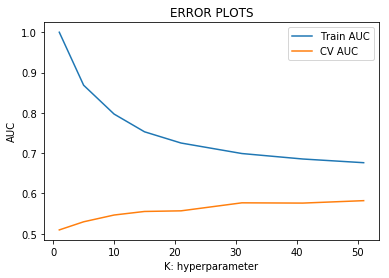

In [189]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(train_avgw2v_dn, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(train_avgw2v_dn)[:,1]
    y_cv_pred =  neigh.predict_proba(cv_avgw2v_dn)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [190]:
### best hyperparameter from curve 
best_k_w2v_kd = 30

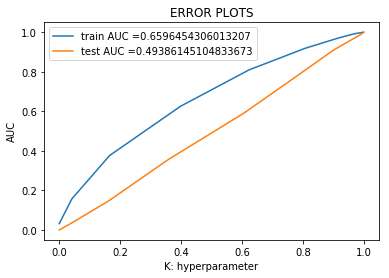

Train confusion matrix
[[    0  2109]
 [    0 17491]]
Test confusion matrix
[[    0  1334]
 [    0 10666]]


In [210]:
neigh = KNeighborsClassifier(n_neighbors=best_k_w2v_kd)
neigh.fit(train_avgw2v_dn, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(train_avgw2v_dn)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(test_avgw2v_dn)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(train_avgw2v_dn)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(test_avgw2v_dn)))

#### Train AUC = 0.65
#### Test AUC = 0.49

#### Classification Information

In [192]:
print(classification_report(y_test, neigh.predict(test_avgw2v_dn)))

             precision    recall  f1-score   support

          0       1.00      0.00      0.00      1334
          1       0.89      1.00      0.94     10666

avg / total       0.90      0.89      0.84     12000



### Tfidf-w2v

In [193]:
#w2v
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())
    
print(type(list_of_sent))
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])


<class 'list'>
witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [194]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [195]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [196]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in (list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [197]:

print(len(tfidf_sent_vectors))
print(np.shape(tfidf_sent_vectors))
print(type(tfidf_sent_vectors))

40000
(40000, 50)
<class 'list'>


In [198]:
# create design matrix X and target vector y
X = np.array(sent_vectors[::]) # end index is exclusive
y = np.array(final['Score']) # showing you two ways of indexing a pandas df

In [199]:
# split the data set into train and test
X_1, X_test_tfidfw2v, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
train_tfidfw2v, cv_tfidfw2v, y_train, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


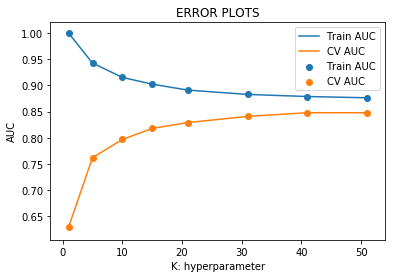

In [200]:
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm = 'brute')
    neigh.fit(train_tfidfw2v, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(train_tfidfw2v)[:,1]
    y_cv_pred =  neigh.predict_proba(cv_tfidfw2v)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [201]:
### best hyperparameter from curve 
best_k_tfidfw2v = 30

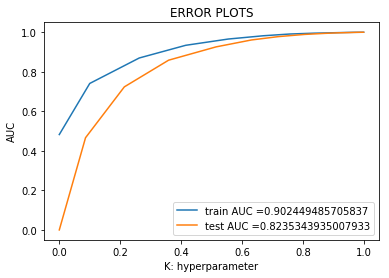

Train confusion matrix
[[  343  1766]
 [   82 17409]]
Test confusion matrix
[[  171  1163]
 [   61 10605]]


In [211]:
neigh = KNeighborsClassifier(n_neighbors=best_k_w2v)
neigh.fit(train_tfidfw2v, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(train_tfidfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_tfidfw2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(train_tfidfw2v)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_tfidfw2v)))

#### Train AUC = 0.90
#### Test AUC = 0.82

#### Classifification information


In [203]:
print(classification_report(y_test,neigh.predict(X_test_tfidfw2v)))

             precision    recall  f1-score   support

          0       0.74      0.13      0.22      1334
          1       0.90      0.99      0.95     10666

avg / total       0.88      0.90      0.86     12000



### Tfidf - w2v KNN(kd tree)

In [204]:
svd = TruncatedSVD()
train_tfidfww2v_dn = svd.fit_transform(train_tfidfw2v)
cv_tfidfww2v_dn = svd.transform(cv_tfidfw2v)
test_tfidfww2v_dn = svd.transform(X_test_tfidfw2v)

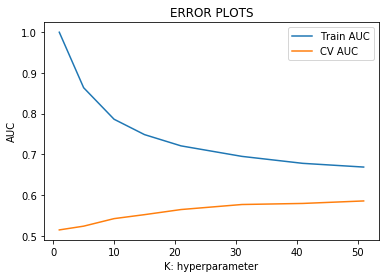

In [205]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(train_tfidfww2v_dn, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(train_tfidfww2v_dn)[:,1]
    y_cv_pred =  neigh.predict_proba(cv_tfidfww2v_dn)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [206]:
best_k_tfidfw2v_kd = 30

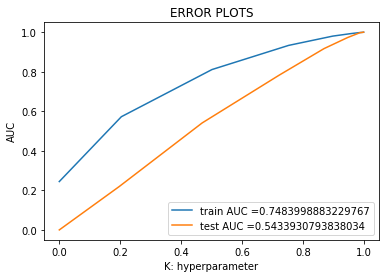

Train confusion matrix
[[   18  2091]
 [   18 17473]]
Test confusion matrix
[[    7  1327]
 [   12 10654]]


In [207]:
neigh = KNeighborsClassifier(n_neighbors=best_k_w2v)
neigh.fit(train_tfidfww2v_dn, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(train_tfidfww2v_dn)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(test_tfidfww2v_dn)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(train_tfidfww2v_dn)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(test_tfidfww2v_dn)))

#### Train AUC = 0.74
#### Test AUC = 0.54

#### Classification Information

In [208]:
print(classification_report(y_test,neigh.predict(test_tfidfww2v_dn)))

             precision    recall  f1-score   support

          0       0.37      0.01      0.01      1334
          1       0.89      1.00      0.94     10666

avg / total       0.83      0.89      0.84     12000



### Conclusion- 
1. As we have taken AUC as performance metric,higher the AUC score, better is the model.
2. The AUC value for tfidf-w2v vectorizer is equal to 0.90 for training and 0.82 for testing which is highest among all vectorizer, therefore this is the best vectorizer using brute force KNN.
3. The AUC value for Avg-w2v vectorizer is equal to 0.65 for training and 0.49 on testing, therefore this vectorizer shows the worst performance of KNN using brute force algorithm.